📋 Tables found in DB: [('superstore',)]


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Profit Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,0.1600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,0.3000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,0.4700
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,-0.4000
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,0.1125


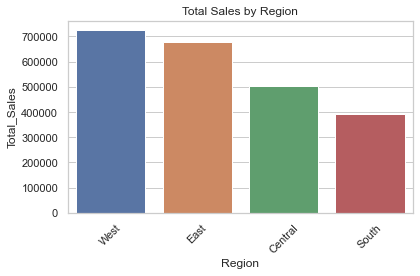

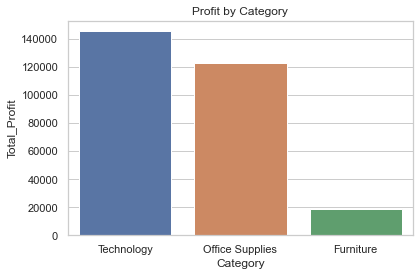

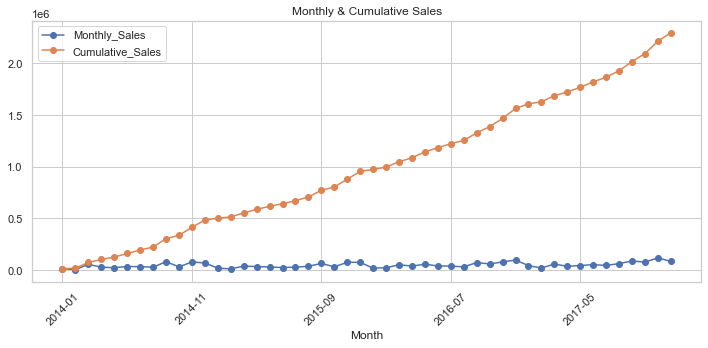

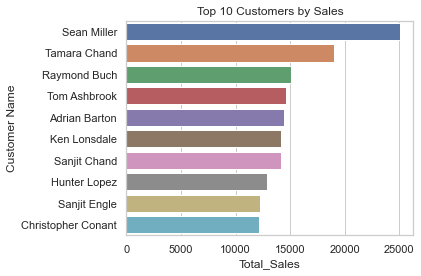

In [2]:
# 📘 SQL Exploration Notebook
# Goal: Analyze retail_data.db using SQLite & Pandas

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 0. Setup ===
sns.set(style='whitegrid')
db_path = "../output/retail_data.db"  # ← adjust if you're running notebook from root

# Connect to DB
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 🔎 List tables to confirm correct table name
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("📋 Tables found in DB:", tables)

# Set the actual table name
# Make sure it matches your `load.py` script!
TABLE_NAME = "superstore"  # ← change if your table is named differently

# Safety check
if (TABLE_NAME,) not in tables:
    raise ValueError(f"❌ Table '{TABLE_NAME}' not found in {db_path}. Found tables: {tables}")

# === 1. Preview Data ===
df = pd.read_sql(f"SELECT * FROM {TABLE_NAME} LIMIT 5", conn)
display(df)

# === 2. Total Sales by Region ===
sql = f'''
SELECT Region, SUM(Sales) AS Total_Sales
FROM {TABLE_NAME}
GROUP BY Region
ORDER BY Total_Sales DESC
'''
region_sales = pd.read_sql(sql, conn)
sns.barplot(data=region_sales, x='Region', y='Total_Sales')
plt.title('Total Sales by Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 3. Profit by Category ===
sql = f'''
SELECT Category, SUM(Profit) AS Total_Profit
FROM {TABLE_NAME}
GROUP BY Category
ORDER BY Total_Profit DESC
'''
category_profit = pd.read_sql(sql, conn)
sns.barplot(data=category_profit, x='Category', y='Total_Profit')
plt.title('Profit by Category')
plt.tight_layout()
plt.show()

# === 4. Monthly Sales & Cumulative Trend ===
sql = f'''
WITH monthly_sales AS (
    SELECT 
        strftime('%Y-%m', [Order Date]) AS Month,
        ROUND(SUM(Sales), 2) AS Monthly_Sales
    FROM {TABLE_NAME}
    GROUP BY Month
)
SELECT 
    Month,
    Monthly_Sales,
    ROUND(SUM(Monthly_Sales) OVER (ORDER BY Month ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW), 2) AS Cumulative_Sales
FROM monthly_sales;
'''
try:
    monthly = pd.read_sql(sql, conn)
    monthly.set_index('Month')[['Monthly_Sales', 'Cumulative_Sales']].plot(figsize=(10, 5), marker='o')
    plt.title('Monthly & Cumulative Sales')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("⚠️ SQLite version might not support window functions.")
    print("Error:", e)

# === 5. Top 10 Customers by Sales ===
sql = f'''
SELECT [Customer Name], ROUND(SUM(Sales), 2) AS Total_Sales
FROM {TABLE_NAME}
GROUP BY [Customer Name]
ORDER BY Total_Sales DESC
LIMIT 10
'''
top_customers = pd.read_sql(sql, conn)
sns.barplot(data=top_customers, y='Customer Name', x='Total_Sales')
plt.title('Top 10 Customers by Sales')
plt.tight_layout()
plt.show()

conn.close()
